# Regression analysis: fitting the yield model

We fit each county individually ensuring coefficients exhibit the correct sign. We then check for which counties the yield model adds significant skill by using an F-test.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import sklearn.preprocessing as sklp
import sklearn.metrics as sklm
import scipy.optimize as sso
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['pdf.fonttype'] = 42

# http://www.fabiocrameri.ch/colourmaps.php
cm_data = np.loadtxt("../../plotting_tools/turku.txt")[::-1]
turku_map = LinearSegmentedColormap.from_list("Turku", cm_data)

In [4]:
# Import plotting shapefiles
county_shp = gp.read_file('../../plotting_tools/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)

states = gp.read_file('../../plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../../plotting_tools/coast_contig_plot.shp')

### Data Processing

In [5]:
# GMFD
gmfd = pd.read_csv('../../agvars/GMFD/agvar_historical_gmfd.csv')
gmfd.sort_values(by = ['GEOID', 'Year'], inplace = True)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd["GEOID"] = gmfd["GEOID"].astype(str).str.zfill(5)
gmfd.set_index(['GEOID', 'Year'], inplace = True)

# USDA with county trends
usda_county = pd.read_csv('../../usda/output/USDA_county_yields_w_county_quad_trends.csv')
usda_county['state_fips_code'] = usda_county["state_fips_code"].astype(str).str.zfill(2)
usda_county["GEOID"] = usda_county["GEOID"].astype(str).str.zfill(5)
usda_county.sort_values(by = ['GEOID', 'year'], inplace = True)
usda_county.set_index(['GEOID', 'year'], inplace = True)

def get_features(usda_data, minYears = 23):
    # Merge
    features = pd.merge(usda_data.query("year <= 2005 and year >= 1960").reset_index().filter(['GEOID', 'year', 'yield_anom', 'log_yield', 'quad_fit']), gmfd.query("Year <= 2005 and Year >= 1960").reset_index(), left_on = ['GEOID', 'year'], right_on = ['GEOID', 'Year'], how = 'inner')
    features.drop(columns = ['Year'], inplace = True)
    features.set_index(['GEOID', 'year'], inplace = True)
    
    # Select minimum number of years for each county
    features['count'] = 1.
    minFeatures = features.groupby('GEOID').sum().query('count >= ' + str(minYears)).index
    # Select minimum number of years for each county
    features = features.loc[minFeatures].drop(columns = ['count'])
    print('Final shape of features: ' + str(features.shape))
    return features

In [4]:
# Features
features = get_features(usda_county)
features['egdd'] = -features['egdd']
features['prcp2'] = -features['prcp2']

Final shape of features: (99403, 7)


In [5]:
features

yield_anom  log_yield  quad_fit          gdd        egdd  \
GEOID year                                                             
01001 1960    0.146259   3.332205  3.185946  2160.636210 -107.991873   
      1961    0.258592   3.465736  3.207144  2093.154949  -62.563605   
      1962   -0.009693   3.218876  3.228569  2255.547685 -149.631965   
      1963    0.333299   3.583519  3.250220  2324.801064 -111.502308   
      1964    0.224410   3.496508  3.272098  2239.600617  -88.277356   
...                ...        ...       ...          ...         ...   
56043 1998    0.063983   4.905275  4.841292   954.775730  -28.236227   
      2001   -0.105717   4.779123  4.884841  1189.443513  -48.652243   
      2002    0.132021   5.030438  4.898417  1041.480326  -44.898459   
      2003   -0.013683   4.897840  4.911523  1113.796246  -59.463231   
      2005   -0.031050   4.905275  4.936325  1024.247038  -37.890111   

                prcp     prcp2  
GEOID year                      
01001 1960  0.693866 -0.481450  
      1961  0.756918 -0.572924  
      1962  0.605531 -0.366668  
      1963  0.642485 -0.412787  
      1964  0.896524 -0.803755  
...              ...       ...  
56043 1998  0.209576 -0.043922  
      2001  0.111998 -0.012543  
      2002  0.123955 -0.015365  
      2003  0.190719 -0.036374  
      2005  0.231419 -0.053555  

[99403 rows x 7 columns]

### Do the full fit

In [6]:
# F-test parameters
pbase = 2
pfull = 6

In [7]:
NNLS = {}
for geoid in features.index.unique(level = 'GEOID'):
    # Predictors, targets
    predictors = sklp.scale(features.loc[geoid].filter(['gdd', 'egdd', 'prcp', 'prcp2']).to_numpy(), with_std=False)
    targets = sklp.scale(features.loc[geoid]['yield_anom'].to_numpy(), with_std=False)
    
    # Scipy NNLS
    model_object = sso.nnls(predictors, targets)
    # R2
    prediction = model_object[0][0]*predictors[:,0] + model_object[0][1]*predictors[:,1] + model_object[0][2]*predictors[:,2] + model_object[0][3]*predictors[:,3]
    r2 = sklm.r2_score(targets, prediction)
    
    # F-test 
    n = len(targets)
    RSSbase = np.sum(targets**2)
    RSSfull = np.sum((prediction - targets)**2)
    F = ((RSSbase - RSSfull)/(pfull-pbase))/(RSSfull/(n-pfull-1))
    pval = ss.f.sf(F, pfull - pbase, n - pfull - 1)
    # Store
    NNLS.update({geoid : [model_object[0][0], -model_object[0][1], model_object[0][2], -model_object[0][3], r2, pval]})
    
NNLS_res = pd.DataFrame.from_dict(NNLS, orient = 'index', columns = ['GDDc', 'KDDc', 'Pc', 'P2c', 'R2', 'pval'])
NNLS_res.index.name = 'GEOID'

In [9]:
# Save
NNLS_res.to_csv('./ag_model_coeff_final.csv')

## Results

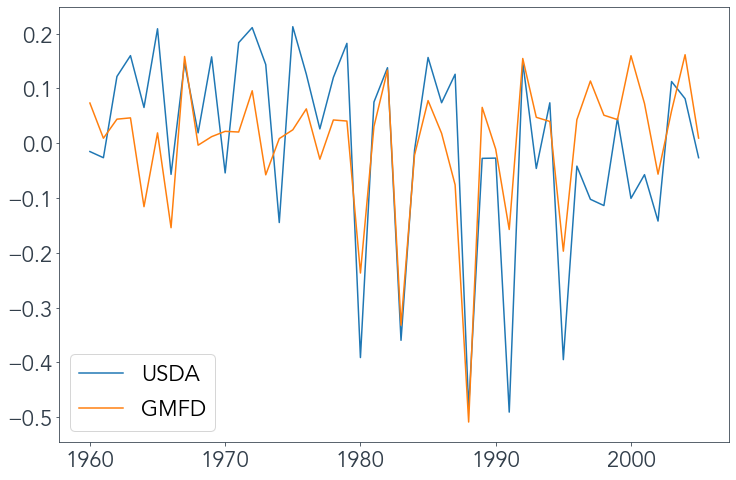

In [11]:
# Example time series
geoid = '17019'
fig, ax = plt.subplots(1,1, figsize = (12,8))
truth = sklp.scale(features.loc[geoid]['yield_anom'], with_std = False)
predictors = sklp.scale(features.loc[geoid].filter(['gdd', 'egdd', 'prcp', 'prcp2']).to_numpy(), with_std=False)
res = NNLS_res.loc[geoid]
sim = res['GDDc']*predictors[:,0] - res['KDDc']*predictors[:,1] + res['Pc']*predictors[:,2] - res['P2c']*predictors[:,3]
ax.plot(features.loc[geoid].index, truth, label = 'USDA')
ax.plot(features.loc[geoid].index, sim, label = 'GMFD')

plt.legend()
plt.show()

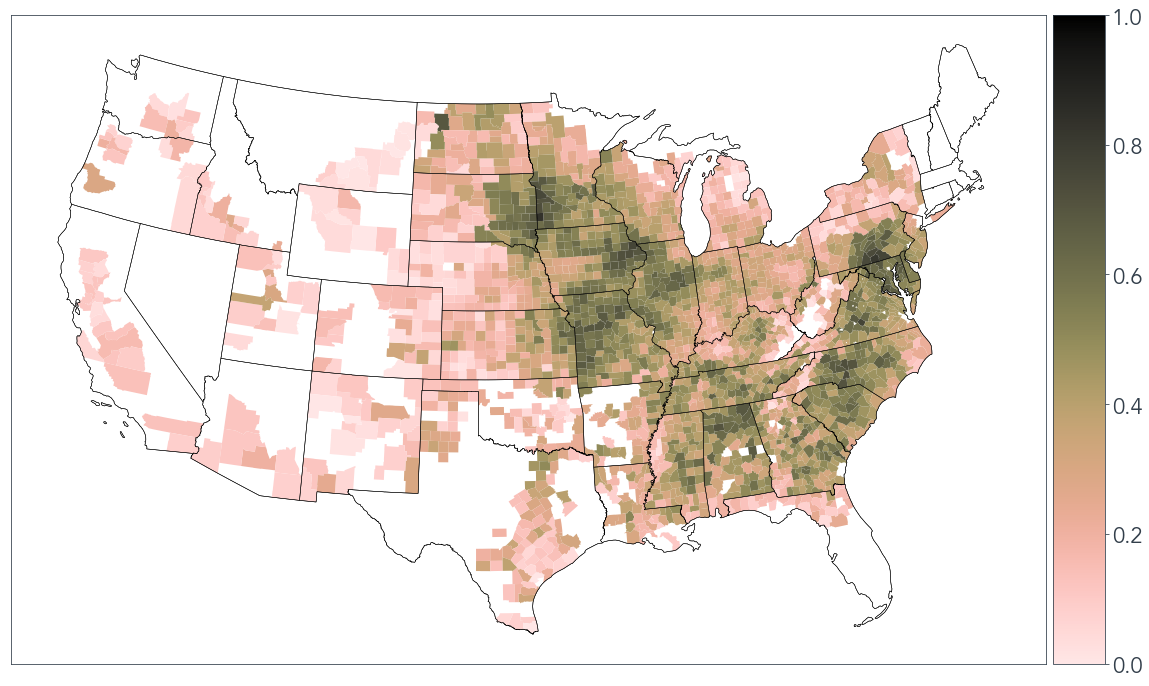

In [165]:
# Plot all R-squared
fig, ax = plt.subplots(1,1, figsize=(18, 10))
data = NNLS_res.reset_index()
data_shp = pd.merge(county_shp, data, on="GEOID", how="outer", copy=False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data_shp.dropna().plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap=turku_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.tight_layout()
plt.show()

### Check where climate variables provide additional skill

In [8]:
# LOO cross-validation
from sklearn.model_selection import KFold
LOO = {}
for geoid in features.index.unique(level = 'GEOID'):
    # LOO
    kf = KFold(n_splits=len(features.loc[geoid]))
    # Full predictors, targets
    predictors = sklp.scale(features.loc[geoid].filter(['gdd', 'egdd', 'prcp', 'prcp2']).to_numpy(), with_std=False)
    targets = sklp.scale(features.loc[geoid]['yield_anom'].to_numpy(), with_std=False)
    # MSE as evaluation metric
    base_mse = []
    full_mse = []
    for train_index, test_index in kf.split(targets):
        # Training
        train_predictors = predictors[train_index,:]
        train_targets = targets[train_index]
        # Scipy NNLS
        model_object = sso.nnls(train_predictors, train_targets)
        # Testing
        test_predictors = predictors[test_index,:]
        test_targets = targets[test_index]
        prediction = model_object[0][0]*test_predictors[:,0] + model_object[0][1]*test_predictors[:,1] + model_object[0][2]*test_predictors[:,2] + model_object[0][3]*test_predictors[:,3]
        full_mse.append(sklm.mean_squared_error(test_targets, prediction))
        # Baseline
        base_mse.append(np.sum(test_targets**2))
        
    # Store
    LOO.update({geoid : [np.mean(base_mse), np.mean(full_mse)]})
    
LOO_res = pd.DataFrame.from_dict(LOO, orient = 'index', columns = ['base', 'full'])
LOO_res.index.name = 'GEOID'

In [9]:
loo_yes = LOO_res.query('full < base').index.unique()
loo_no = LOO_res.query('full > base').index.unique()
print(len(loo_yes))
print(len(LOO_res))

1816
2371


In [33]:
# Save
pd.DataFrame(loo_yes).to_csv('loo_yes.csv', index=False)
pd.DataFrame(loo_no).to_csv('loo_no.csv', index=False)

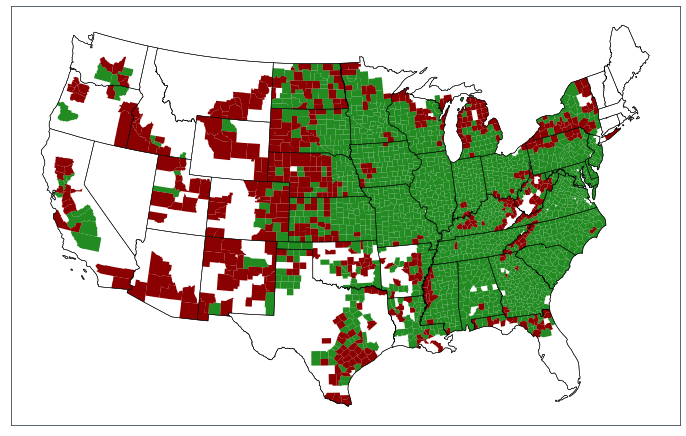

In [19]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(10, 15))
yes_shp = county_shp.set_index('GEOID').loc[loo_yes]
no_shp = county_shp.set_index('GEOID').loc[loo_no]

divider = make_axes_locatable(ax)
yes_shp.plot(ax=ax, legend=False, color='forestgreen')
no_shp.plot(ax=ax, legend=False, color='darkred')
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.tight_layout()
plt.savefig('../../figs/SIfigs_loo_yesno.png', dpi=900)

## Figure 1

Note this will only correspond exactly to Figure 1 in the main text if `f_tested = False` and `weighted = True` above. Other combinations can be found in the Supplementary Information.

In [3]:
# If needed
NNLS_res = pd.read_csv('./ag_model_coeff_final.csv')
NNLS_res['GEOID'] = NNLS_res['GEOID'].astype(str).str.zfill(5)
NNLS_res.set_index('GEOID', inplace=True)

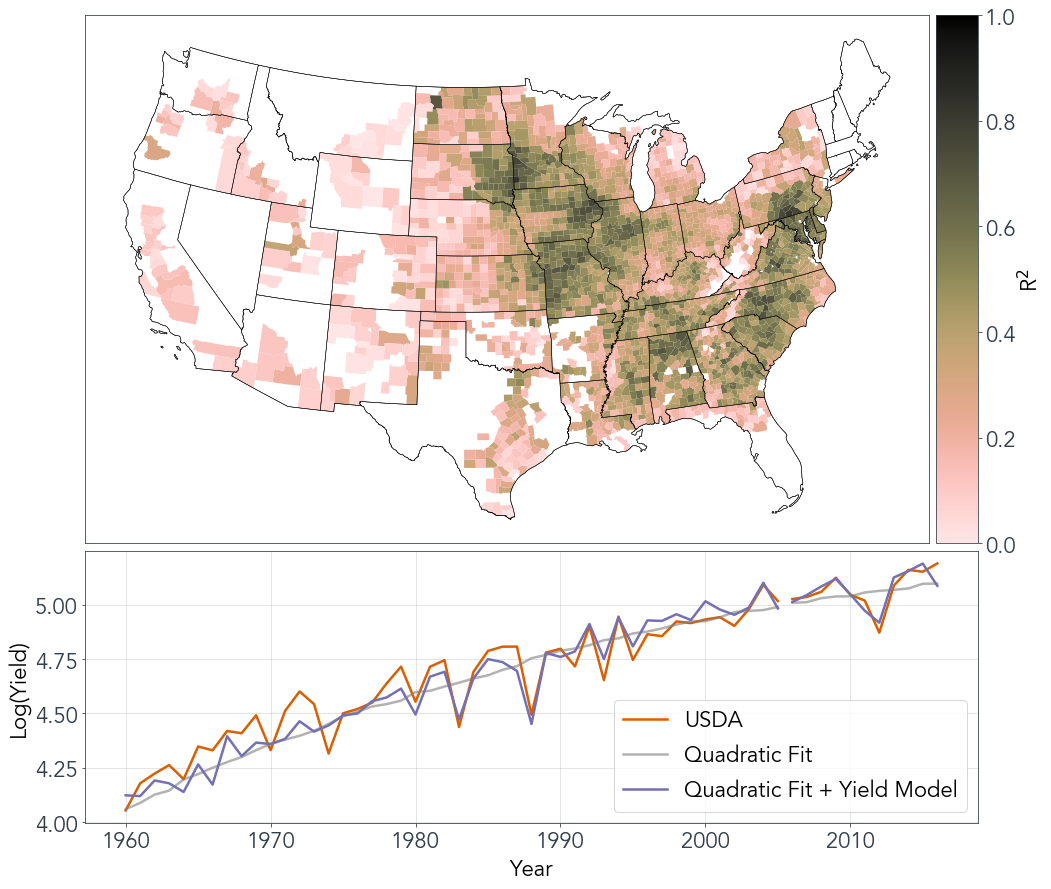

In [11]:
###############################
# Select aggregation options
f_tested = False     # if True, include counties with F-test p-value < 0.05
loo_tested = False   # if True, include counties with improvements in LOO-CV score
weighted = True    # if True, do weighted aggregation based on historical county production shares
###############################

# Calculate the postdictions
gmfd_plot = gmfd.copy()
gmfd_plot['prcp2'] = gmfd_plot['prcp']**2
    
# Subtract means
for agvar in gmfd_plot.columns:
    gmfd_plot[agvar] = gmfd_plot[agvar] - gmfd_plot[agvar].mean(level = 'GEOID')
gmfd_plot = pd.merge(gmfd_plot.reset_index(), NNLS_res.reset_index(), on=['GEOID'], how = 'inner')
gmfd_plot['gmfd_yield'] = gmfd_plot['gdd']*gmfd_plot['GDDc'] + gmfd_plot['egdd']*gmfd_plot['KDDc'] + gmfd_plot['prcp']*gmfd_plot['Pc'] + gmfd_plot['prcp2']*gmfd_plot['P2c']

# Select what we need for plot
gmfd_plot = pd.merge(usda_county.reset_index().filter(['GEOID', 'year', 'yield_anom', 'log_yield', 'quad_fit']), gmfd_plot.reset_index().filter(['GEOID', 'Year', 'gmfd_yield']), left_on = ['GEOID', 'year'], right_on = ['GEOID', 'Year'], how = 'inner')
gmfd_plot.drop(columns = ['Year'], inplace = True)
gmfd_plot.set_index(['GEOID', 'year'], inplace = True)

# County filter
if f_tested:
    p05_counties = NNLS_res.query('pval < 0.05').index.unique()
    gmfd_plot = gmfd_plot.loc[p05_counties]
elif loo_tested:
    gmfd_plot = gmfd_plot.loc[loo_counties]

# Weight function (different if applied with(out) F-test filtering)
def do_weighting(data):
    # Construct national weights (total production by weighted sum of counties)
    weights = usda_county.filter(["area","yield"])
    weights["national_weight"] = weights["area"] * weights["yield"]
    weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
    # Normalise
    weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
    weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
    weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
    weights = weights.set_index(['GEOID','year']).sort_index()
    weights = weights.filter(['national_weight'])
    # Merge
    data = pd.merge(data.reset_index(), weights.reset_index(), on = ['GEOID','year'], how = 'inner')
    data.set_index(['GEOID', 'year'], inplace = True)
    
    # Sum
    data['gmfd_yield'] = data['gmfd_yield'] * data['national_weight']
    data['quad_fit'] = data['quad_fit'] * data['national_weight']
    data['log_yield'] = data['log_yield'] * data['national_weight']
    data = data.groupby('year').sum()
    return data

# Do weighting if selected
if weighted:
    gmfd_plot = do_weighting(gmfd_plot)
else:
    gmfd_plot = gmfd_plot.mean(level='year')

# Split for figure
gmfd_hist_plot = gmfd_plot.query("year <= 2005 and year >= 1960")
gmfd_oos_plot = gmfd_plot.query("year >= 2006").sort_index()

##############################
############# Final plot
##############################
fig, axs = plt.subplots(2,1, figsize=(16, 15), gridspec_kw = {'height_ratios' : [2,1], 'hspace' : 0.0005})

# Selected Counties
if f_tested:
    data_shp_yes = pd.merge(county_shp, NNLS_res.loc[p05_counties], on="GEOID", how="inner", copy=False)
    data = NNLS_res.query('pval > 0.05').reset_index()
    data_shp_no = pd.merge(county_shp, data, on="GEOID", how="inner", copy=False)
elif loo_tested:
    data_shp_yes = pd.merge(county_shp, NNLS_res.loc[loo_yes], on="GEOID", how="inner", copy=False)
    data_shp_no = pd.merge(county_shp, NNLS_res.loc[loo_no], on="GEOID", how="inner", copy=False)

# Plot R-squared
ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
if f_tested or loo_tested:
    data_shp_no.plot(ax=ax, linewidth=0.5, edgecolor="gray", color='lightgray')
    data_shp_yes.plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'R$^2$', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap = turku_map)
else:
    data_shp = pd.merge(county_shp, NNLS_res, on="GEOID", how="inner", copy=False)
    data_shp.plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'R$^2$', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap = turku_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

# Plot time series
ax = axs[1]
gmfd_hist_plot['log_yield'].plot(ax = ax, label = 'USDA', color = '#d95f02', linewidth=2.5)
gmfd_hist_plot['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6, label = 'Quadratic Fit', linewidth=2.5)
ax.plot(gmfd_hist_plot.index, gmfd_hist_plot['quad_fit'] + gmfd_hist_plot['gmfd_yield'], label = 'Quadratic Fit + Yield Model', color='#7570b3', linewidth=2.5)
ax.legend()
gmfd_oos_plot['log_yield'].plot(ax = ax, color = '#d95f02', linewidth=2.5)
gmfd_oos_plot['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6, linewidth=2.5)
ax.plot(gmfd_oos_plot.index, gmfd_oos_plot['quad_fit'] + gmfd_oos_plot['gmfd_yield'], linewidth=2.5, color='#7570b3')
ax.set_ylabel('Log(Yield)')
ax.set_xlabel('Year')
ax.grid(zorder=10, alpha=0.4)
# plt.show()
plt.savefig('../../figs/SIfigs_oldfigure1.png', dpi=900)

In [134]:
# National-level training period R-squared
sklm.r2_score(gmfd_hist_plot['log_yield'] - gmfd_hist_plot['quad_fit'], gmfd_hist_plot['gmfd_yield'])

0.4857647885633628

In [135]:
# National-level tresting period R-squared
sklm.r2_score(gmfd_oos_plot['log_yield'] - gmfd_oos_plot['quad_fit'], gmfd_oos_plot['gmfd_yield'])

0.7083008855473286

In [136]:
# Median county-level R-squared for all counties
NNLS_res['R2'].median()

0.34668178206006295

In [138]:
# Median county-level R-squared for select counties
NNLS_res.loc[loo_yes]['R2'].median()

0.40541779899798064

### Supplementary Information: Entire 1960-2005 $R{^2}$ map (all counties included)

In [10]:
# If needed
NNLS_res = pd.read_csv('./ag_model_coeff_final.csv')
NNLS_res['GEOID'] = NNLS_res['GEOID'].astype(str).str.zfill(5)

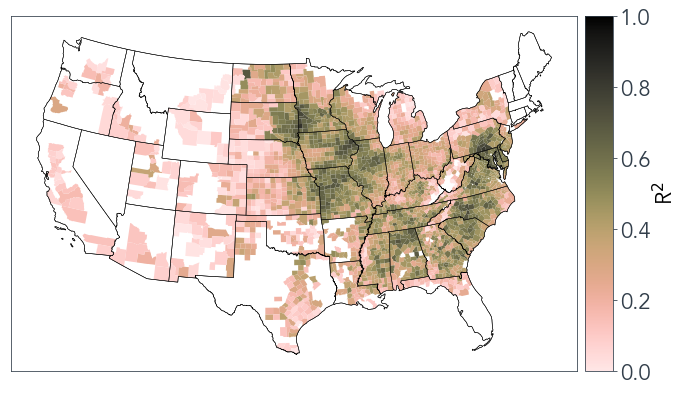

In [11]:
# Merge
NNLS_res_plot = pd.merge(county_shp, NNLS_res, on="GEOID", how="inner", copy=False)

##############################
############# Final plot
##############################
fig, ax = plt.subplots(1,1, figsize=(10, 15))

# Plot R-squared
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
NNLS_res_plot.plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'R$^2$', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap = turku_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
# plt.show()
plt.tight_layout()
plt.savefig('../../figs/SIfig_r2_all.jpg', dpi=900)

### Supplementary Information: Out-of-sample (2006-2016) $R{^2}$ map

In [34]:
# If needed
NNLS_res = pd.read_csv('./ag_model_coeff_final.csv')
NNLS_res['GEOID'] = NNLS_res['GEOID'].astype(str).str.zfill(5)
NNLS_res.set_index(['GEOID'], inplace=True)
p05_counties = NNLS_res.query('pval < 0.05').index.unique()

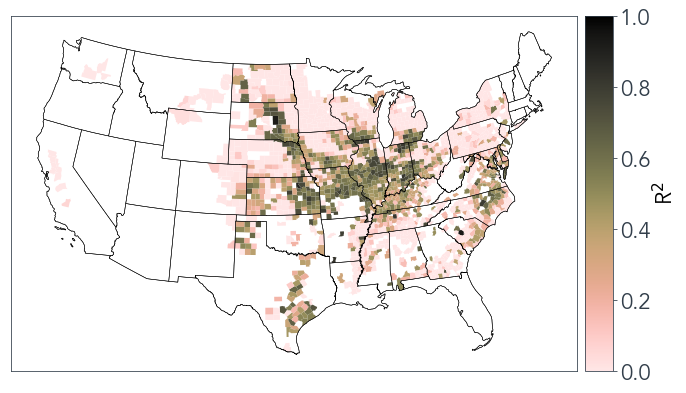

In [36]:
# Calculate the postdictions
gmfd_plot = gmfd.copy().query("Year > 2005")
gmfd_plot['prcp2'] = gmfd_plot['prcp']**2
    
# Subtract means
for agvar in ['gdd','egdd','prcp','prcp2']:
    gmfd_plot[agvar] = gmfd_plot[agvar] - gmfd_plot[agvar].mean(level = 'GEOID')
gmfd_plot = pd.merge(gmfd_plot.reset_index(), NNLS_res.reset_index(), on=['GEOID'], how = 'inner')
gmfd_plot['gmfd_yield'] = gmfd_plot['gdd']*gmfd_plot['GDDc'] + gmfd_plot['egdd']*gmfd_plot['KDDc'] + gmfd_plot['prcp']*gmfd_plot['Pc'] + gmfd_plot['prcp2']*gmfd_plot['P2c']

# Select what we need for plot
gmfd_plot = pd.merge(usda_county.reset_index().filter(['GEOID', 'year', 'yield_anom', 'log_yield', 'quad_fit']), gmfd_plot.reset_index().filter(['GEOID', 'Year', 'gmfd_yield']), left_on = ['GEOID', 'year'], right_on = ['GEOID', 'Year'], how = 'inner')
gmfd_plot.drop(columns = ['Year'], inplace = True)
gmfd_plot.set_index(['GEOID', 'year'], inplace = True)

# OOS
gmfd_oos_plot = gmfd_plot.query("year > 2005").sort_index()

# R-squared
r2_scores = {}
for geoid in gmfd_oos_plot.index.unique(level='GEOID'):
    if len(gmfd_oos_plot.loc[geoid]) >= 6:
        r2_score = sklm.r2_score(gmfd_oos_plot.loc[geoid]['yield_anom'],gmfd_oos_plot.loc[geoid]['gmfd_yield'])
        r2_scores.update({geoid : r2_score})
r2_scores = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R2'])
r2_scores.index.name = 'GEOID'

# Merge
r2_scores_plot = pd.merge(county_shp, r2_scores, on="GEOID", how="inner", copy=False)

##############################
############# Final plot
##############################
fig, ax = plt.subplots(1,1, figsize=(10, 15))

# Plot R-squared
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
r2_scores_plot.plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'R$^2$', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap = turku_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.tight_layout()
# plt.show()
plt.savefig('../../figs/SIfig_oos_r2.png', dpi=900)

In [265]:
# Out-of-sample R2 median
r2_scores.median()

R2    0.140974
dtype: float64

In [266]:
# Out-of-sample R2 median
r2_scores.loc[r2_scores.index.intersection(loo_yes)].median()

R2    0.202761
dtype: float64

In [267]:
# Out-of-sample R2 median
r2_scores.loc[r2_scores.index.intersection(p05_counties)].median()

R2    0.217998
dtype: float64

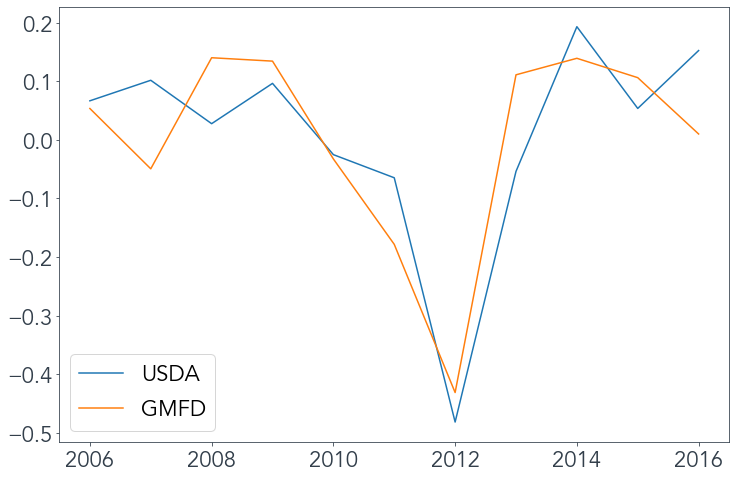

In [261]:
# Example time series
geoid = '17019'
fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(gmfd_plot.loc[geoid].index, gmfd_plot.loc[geoid]['yield_anom'], label = 'USDA')
ax.plot(gmfd_plot.loc[geoid].index, gmfd_plot.loc[geoid]['gmfd_yield'], label = 'GMFD')

plt.legend()
plt.show()

### Supplementary Information: Spatial Autocorrelation

In [2]:
###### Required libraries #####
import libpysal
import esda

In [7]:
# If needed
NNLS_res = pd.read_csv('./ag_model_coeff_final.csv')
NNLS_res['GEOID'] = NNLS_res['GEOID'].astype(str).str.zfill(5)
NNLS_res.set_index(['GEOID'], inplace=True)
loo_counties = pd.read_csv('./loo_yes.csv')['GEOID'].astype(str).str.zfill(5)
NNLS_res = NNLS_res.loc[loo_counties] # Select counties

In [8]:
# Get residuals
gmfd_plot = gmfd.copy().query("Year >= 1960 and Year <= 2005")
gmfd_plot['prcp2'] = gmfd_plot['prcp']**2
    
# Subtract means
for agvar in ['gdd','egdd','prcp','prcp2']:
    gmfd_plot[agvar] = gmfd_plot[agvar] - gmfd_plot[agvar].mean(level = 'GEOID')
gmfd_plot = pd.merge(gmfd_plot.reset_index(), NNLS_res.reset_index(), on=['GEOID'], how = 'inner')
gmfd_plot['gmfd_yield'] = gmfd_plot['gdd']*gmfd_plot['GDDc'] + gmfd_plot['egdd']*gmfd_plot['KDDc'] + gmfd_plot['prcp']*gmfd_plot['Pc'] + gmfd_plot['prcp2']*gmfd_plot['P2c']

# Select what we need for plot
gmfd_plot = pd.merge(usda_county.reset_index().filter(['GEOID', 'year', 'yield_anom']), gmfd_plot.reset_index().filter(['GEOID', 'Year', 'gmfd_yield']), left_on = ['GEOID', 'year'], right_on = ['GEOID', 'Year'], how = 'inner')
gmfd_plot['resid'] = gmfd_plot['yield_anom'] - gmfd_plot['gmfd_yield']
gmfd_plot.drop(columns = ['Year'], inplace = True)

# Merge
gmfd_plot = pd.merge(county_shp, gmfd_plot, on="GEOID", how="inner", copy=False)

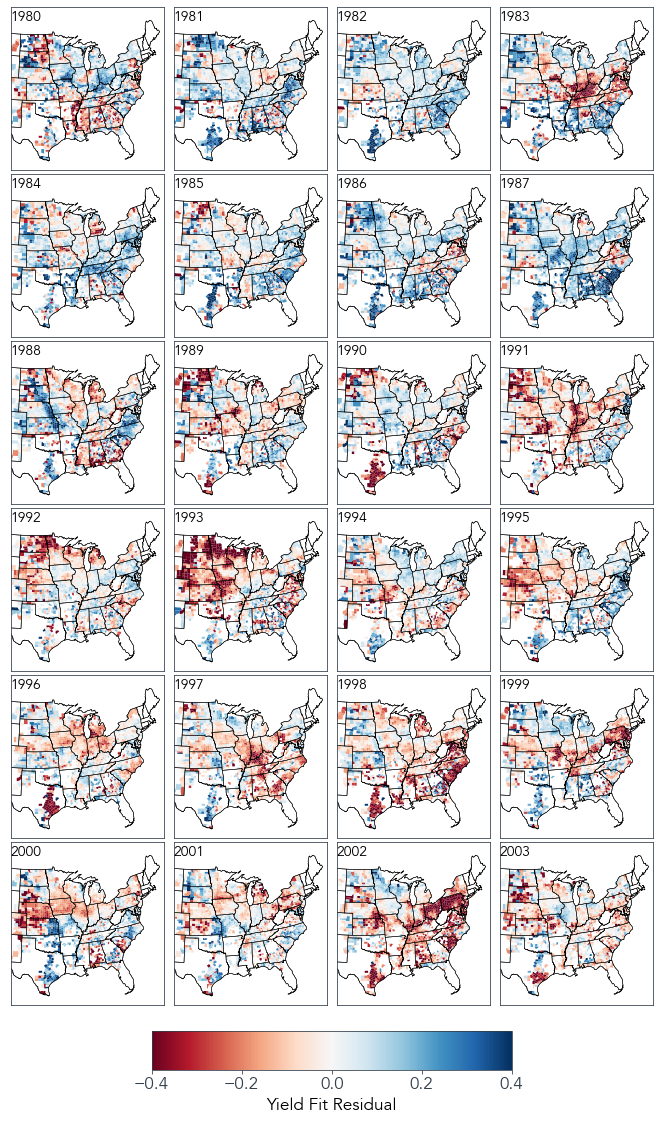

In [40]:
# Spacetime structure of residuals
fig = plt.figure(figsize=(10, 18))
gs = gridspec.GridSpec(nrows = 6, ncols = 4, wspace=0.025, hspace=0.025)
gs.update(top = 0.95, bottom = 0.18, left = 0.05, right = 0.95)
cax = fig.add_axes([0.25, 0.13, 0.5, 0.03])
plt.rcParams['font.size'] = 17

for i in range(24):
    ax = plt.subplot(gs[i])
    gmfd_plot.query('year == ' + str(1980+i)).plot(column='resid', ax=ax, cax = cax, legend=False, cmap='RdBu', vmin=-0.4, vmax=0.4)
    states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
    ax.set_ylim([-2300000,1000000])
    ax.set_xlim([-500000,2600000])
    ax.set_title(str(1980+i), loc = 'left', pad = -14, size=14)

# Colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-0.4, vmax=0.4))
sm._A = []
fig.colorbar(sm, cax=cax, orientation = 'horizontal', label = 'Yield Fit Residual')

# Show
# plt.show()
plt.savefig('../../figs/SIfig_resid_maps.png', dpi=900)

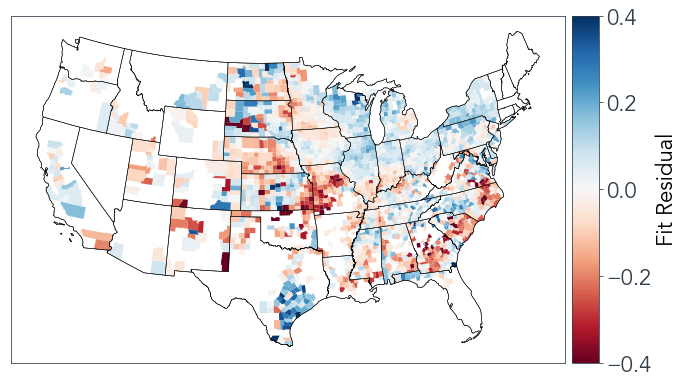

In [104]:
# Example plot for specific year
fig, ax = plt.subplots(1,1, figsize=(10, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gmfd_plot.query('year == 1994').plot(column='resid', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'Fit Residual'}, cmap='RdBu', vmin=-0.4, vmax=0.4)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.tight_layout()
plt.savefig('../../figs/SIfig_1994_resid.jpg', dpi=900)
# plt.show()

In [9]:
# Calculate Moran's I for each year (all counties)
moranI = []
gearyC = []
for year in np.arange(1960,2006,1):
    dat = gmfd_plot.query('year == ' + str(year))
    weights = libpysal.weights.distance.KNN.from_dataframe(dat, k=10)
    geary = esda.geary.Geary(dat[['resid']], weights)  # calculate Geary's C
    moran = esda.Moran(dat[['resid']], weights)  # calculate Moran's I
    moranI.append(moran.I)
    gearyC.append(geary.C)

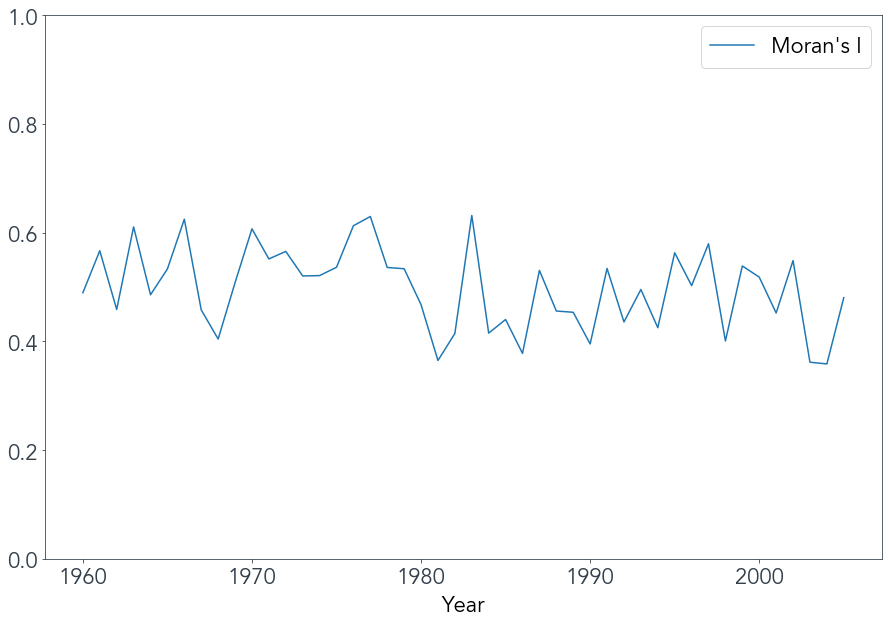

In [10]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.plot(np.arange(1960,2006,1), moranI, label = "Moran's I")
# ax.plot(np.arange(1960,2006,1), gearyC, label = "Geary's C")
ax.set_xlabel('Year')
ax.set_ylim([0.,1.])
ax.legend()
plt.savefig('../../figs/SIfig_spatial_autocorr_ts.pdf')
# plt.show()

### Supplementary Information: Mean county production shares

In [3]:
# Construct national weights (total production by weighted sum of counties)
usda_county = pd.read_csv('../../usda/output/USDA_county_yields_w_county_quad_trends.csv')
usda_county = usda_county.query('year >= 1960 and year <= 2016')
usda_county['state_fips_code'] = usda_county["state_fips_code"].astype(str).str.zfill(2)
usda_county["GEOID"] = usda_county["GEOID"].astype(str).str.zfill(5)
usda_county.sort_values(by = ['GEOID', 'year'], inplace = True)
usda_county.set_index(['GEOID', 'year'], inplace = True)

weights = usda_county.filter(["area","yield"])
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])

# Normalise and average
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])
weights = weights.mean(level='GEOID')

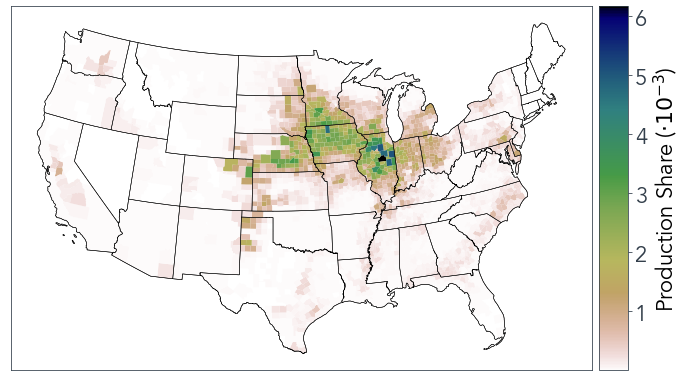

In [5]:
# Plot
weights_plot = pd.merge(county_shp, weights.reset_index(), on="GEOID", how="inner", copy=False)
weights_plot['national_weight'] = weights_plot['national_weight']*1000

fig, ax = plt.subplots(1,1, figsize=(10, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
weights_plot.plot(column='national_weight', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'Production Share ($ \cdot 10^{-3}$)'}, cmap='gist_earth_r')
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
# plt.show()
plt.tight_layout()
plt.savefig('../../figs/SIfig_mean_production_shares.jpg', dpi=900)

### Supplementary Information: select counties production share

In [5]:
loo_yes = pd.read_csv('./loo_yes.csv')['GEOID'].astype(str).str.zfill(5)

In [7]:
# Construct national weights (total production by weighted sum of counties)
usda_county = pd.read_csv('../../usda/output/USDA_county_yields_w_county_quad_trends.csv')
usda_county = usda_county.query('year >= 1960 and year <= 2016')
usda_county['state_fips_code'] = usda_county["state_fips_code"].astype(str).str.zfill(2)
usda_county["GEOID"] = usda_county["GEOID"].astype(str).str.zfill(5)
usda_county.sort_values(by = ['GEOID', 'year'], inplace = True)
usda_county.set_index(['GEOID', 'year'], inplace = True)

weights = usda_county.filter(["area","yield"])
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])

# Normalise and average
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])

In [8]:
# Get fraction of total
# weights = weights.loc[p05_counties]
weights = weights.loc[loo_yes]

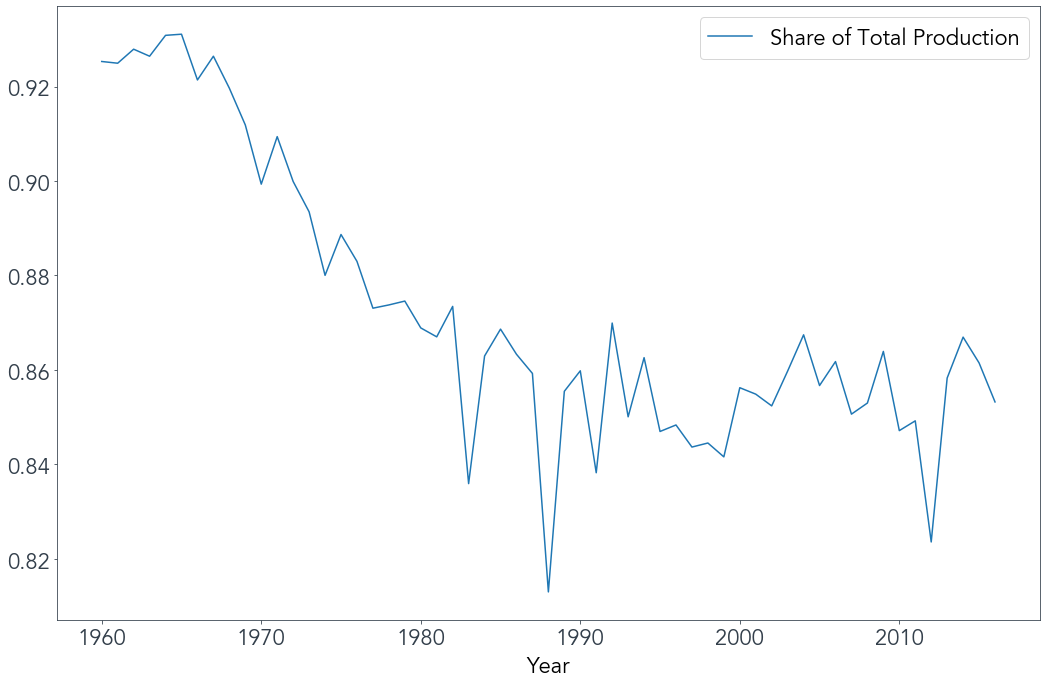

In [10]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(15,10))
weights.sum(level='year').sort_index().plot(ax=ax, legend=False)
ax.set_xlabel('Year')
ax.legend(['Share of Total Production'])
plt.tight_layout()
plt.savefig('../../figs/SIfig_LOOyes_share.pdf')
# plt.show()